In [71]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


Import necesaary libraries.

In [72]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning Libraries
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler

Read the dataset into a dataframe.


In [73]:
df=pd.read_csv("/content/gdrive/My Drive/DataAnalysis/Parkinson/parkinsons.data")

In [74]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


##Metadata regarding on the dataset.

In [75]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


This dataset can be used for building a model in order to make classification of healthy and PD. 

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

Only *status* field is a categorical variable and other columns are continious variables.

In [77]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

There is no empty field in the dataset which is a good thing because we can get started on analyzing the dataset.

## EDA

###Target class distributions.

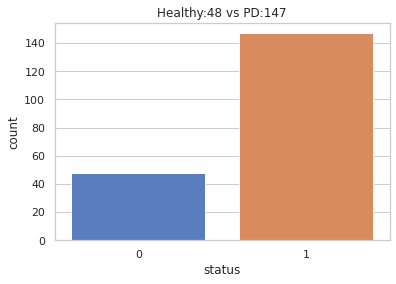

In [78]:
sns.countplot(df.status)
PD,H = df.status.value_counts()
plt.title("Healthy:"+str(H)+ " vs "+"PD:"+str(PD))
plt.show()

###Violinplot

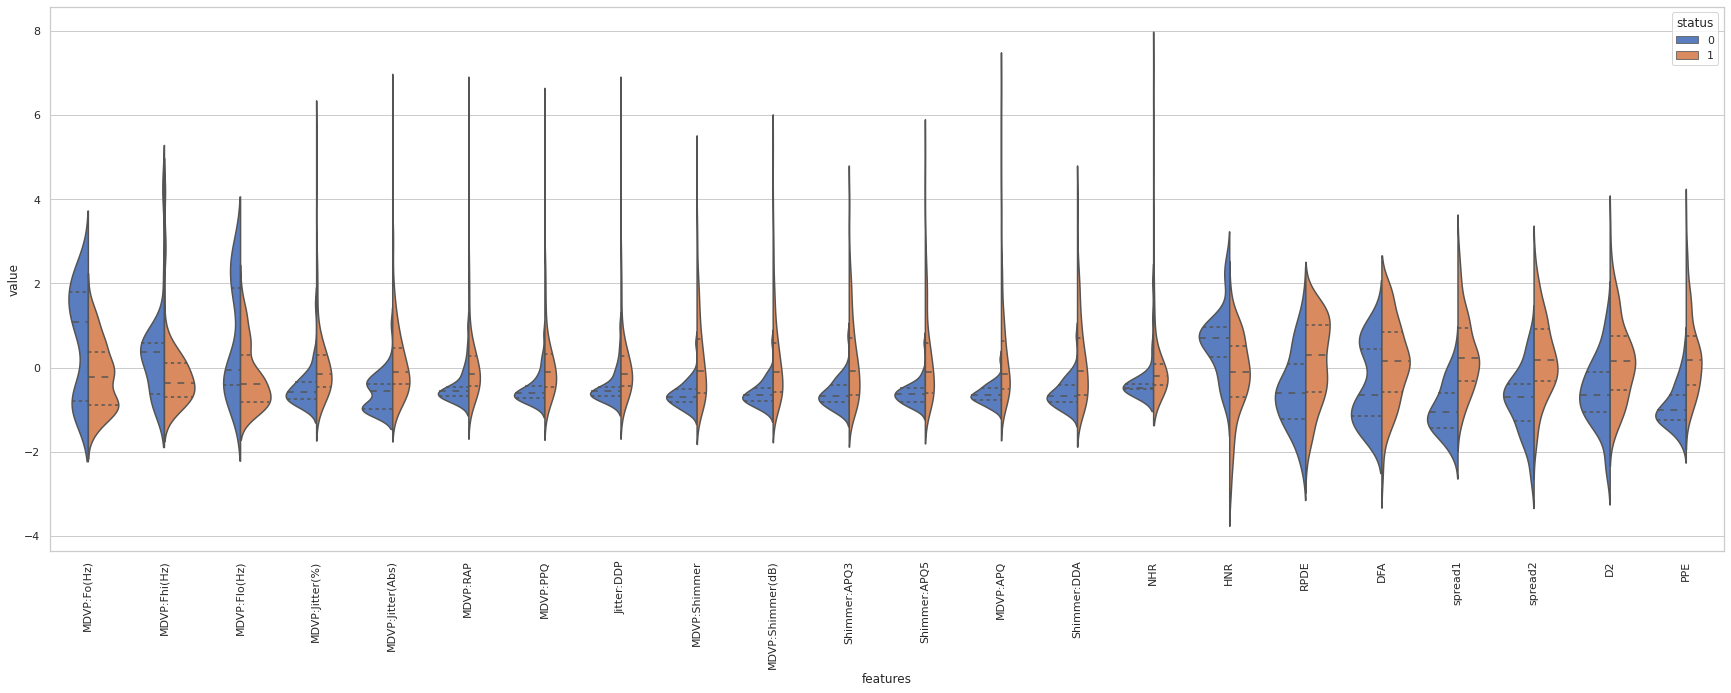

In [79]:
data_ = df.status
data = df.drop(columns=["status","name"],inplace=False)
data_n_2 = (data - data.mean()) / (data.std())              
data = pd.concat([data_,data_n_2],axis=1)
data = pd.melt(data,id_vars="status",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,10))
sns.violinplot(x="features", y="value", hue="status", data=data,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

###Swarmplot
* Since there is not many instance of data we can get a good view from this plot.

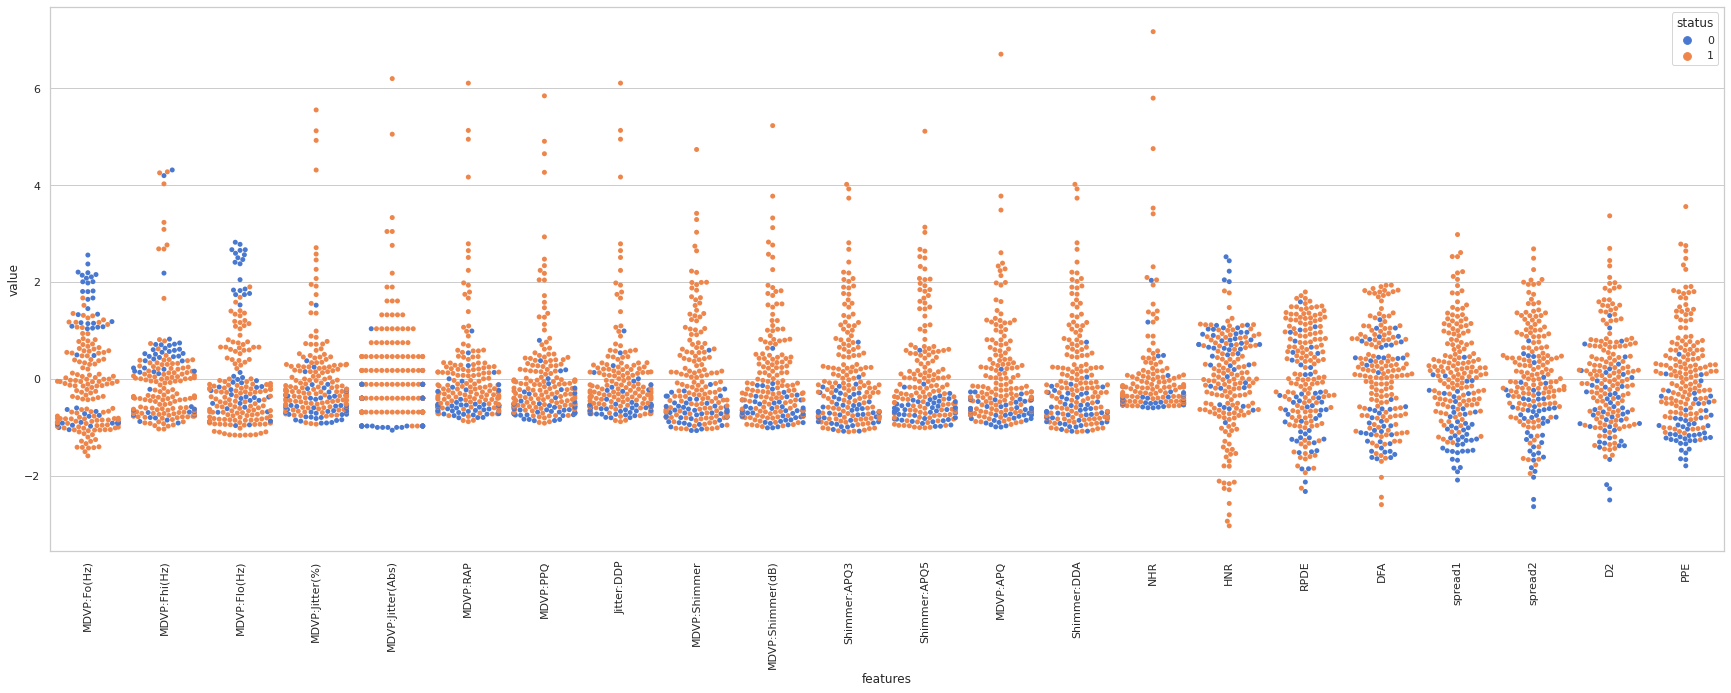

In [80]:
sns.set(style="whitegrid", palette="muted")
data_ = df.status
data = df.drop(columns=["status","name"],inplace=False)
data_n_2 = (data - data.mean()) / (data.std())              
data = pd.concat([data_,data_n_2],axis=1)
data = pd.melt(data,id_vars="status",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,10))
sns.swarmplot(x="features", y="value", hue="status", data=data)

plt.xticks(rotation=90)
plt.show()

The swarmplot shows that there exists some noisy points which could cause our model to work wrongly and in order to solve this feature engineering might be necessary.

###Correlation Matrix Using Heatmap
* Before moving on working with models we can use a correlation matrix since some models such as Naive Bayes can get affected with related features.
* If there exist a linear relation between some features correlation matrix will help us to identify those features.

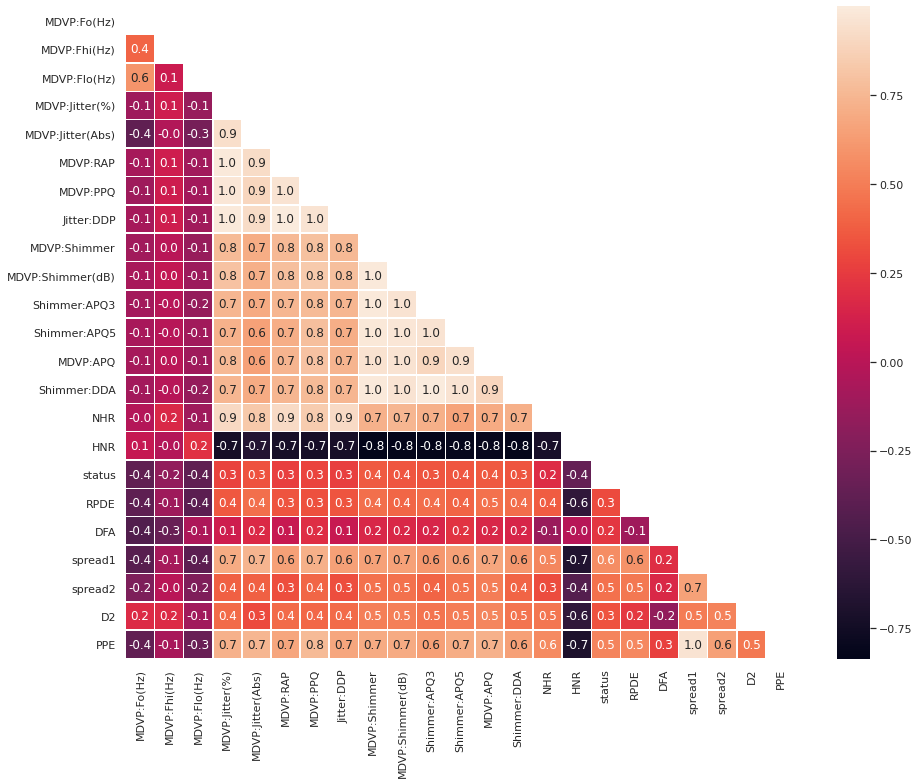

In [81]:
fig, ax = plt.subplots(figsize=(15,12))         # Sample figsize in inches
sns.heatmap(df.drop(columns=["name"]).corr(), annot=True, linewidths=.5,ax=ax, fmt= '.1f',mask= np.triu(np.ones_like(df.drop(columns=["name"]).corr(), dtype=np.bool)))

##Data Preprocessing


In [82]:
features = df.drop(columns=["status","name"])
target = pd.DataFrame(df["status"],columns=["status"])

In [83]:
target.head()

,status
0,1
1,1
2,1
3,1
4,1


In [84]:
features.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [85]:
features.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Standard Scaling (Standardisation) is useful when there is a gaussian dist. in the dataset fields and when our algorithm makes assumptions regarding on the dataset.

Normalizing the data is sensitive to outliers, so if there are outliers in the data set it is a bad practice. Standardization creates a new data not bounded (unlike normalization).

In [86]:
features = pd.DataFrame(StandardScaler().fit_transform(features),columns=features.columns)

In [87]:
features.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,-0.829300,-0.436165,-0.952037,0.334914,0.749759,0.132963,0.760800,0.131755,0.745985,0.739536,0.607859,1.119147,0.332985,0.607532,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886
1,-0.770972,-0.530974,-0.057721,0.715418,1.037674,0.453892,1.276809,0.452684,1.681731,1.768464,1.547912,2.276504,1.159454,1.548254,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605
2,-0.909476,-0.723168,-0.109875,0.884991,1.325589,0.720770,1.585687,0.721813,1.202693,1.027636,1.175643,1.726176,0.699187,1.175323,-0.291633,-0.279760,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661
3,-0.909622,-0.649092,-0.114229,0.775389,1.325589,0.578885,1.284076,0.577677,1.340396,1.207698,1.340547,1.848749,0.806859,1.340229,-0.280719,-0.281346,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954
4,-0.925657,-0.606245,-0.130608,1.368893,1.901418,1.095750,2.047187,1.096793,1.836448,1.552389,1.899444,2.532491,1.216839,1.899461,-0.178026,-0.506745,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082


In [88]:
features.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,3.529940e-17,-2.237526e-16,1.309494e-16,-2.127927e-17,2.562053e-18,-1.380662e-16,9.351494e-17,1.015569e-16,2.818258e-16,-1.374969e-16,8.255505e-17,1.930080e-16,-8.824850e-17,-1.577086e-16,5.152574e-17,8.770762e-16,-1.913000e-16,5.687758e-16,1.184451e-15,-1.429056e-16,-6.117614e-16,-2.960595e-17
std,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00
min,-1.596162e+00,-1.040581e+00,-1.171366e+00,-9.389487e-01,-1.064103e+00,-8.872543e-01,-9.180440e-01,-8.873331e-01,-1.072340e+00,-1.014787e+00,-1.097467e+00,-1.015461e+00,-9.993055e-01,-1.097815e+00,-6.002051e-01,-3.045707e+00,-2.333888e+00,-2.605676e+00,-2.097268e+00,-2.647338e+00,-2.510472e+00,-1.802384e+00
25%,-8.879183e-01,-6.820590e-01,-7.379376e-01,-5.708520e-01,-6.898141e-01,-5.561906e-01,-5.764609e-01,-5.557071e-01,-7.020291e-01,-6.881025e-01,-7.326044e-01,-6.919345e-01,-6.508513e-01,-7.326182e-01,-4.693595e-01,-6.089102e-01,-7.449206e-01,-7.852617e-01,-7.041503e-01,-6.269844e-01,-7.404100e-01,-7.687420e-01
50%,-1.317379e-01,-2.331437e-01,-2.766579e-01,-2.647942e-01,-4.018994e-01,-2.724216e-01,-2.748504e-01,-2.736279e-01,-3.583019e-01,-3.151160e-01,-2.838083e-01,-3.675741e-01,-3.444009e-01,-2.841460e-01,-3.271036e-01,4.508553e-02,-2.490033e-02,7.527941e-02,-3.353960e-02,-9.166005e-02,-5.315145e-02,-1.390580e-01
75%,6.913210e-01,2.969710e-01,5.458200e-01,2.366858e-01,4.618447e-01,1.785683e-01,1.848331e-01,1.784870e-01,4.346898e-01,3.485429e-01,4.543106e-01,3.753694e-01,3.146448e-01,4.543110e-01,1.966835e-02,7.225273e-01,8.587132e-01,7.932500e-01,5.869042e-01,6.337615e-01,6.668912e-01,5.165137e-01
max,2.564598e+00,4.327631e+00,2.829908e+00,5.570985e+00,6.220139e+00,6.125892e+00,5.862742e+00,6.126923e+00,4.751617e+00,5.246243e+00,4.029374e+00,5.129875e+00,6.726438e+00,4.029746e+00,7.192738e+00,2.528321e+00,1.800007e+00,1.942048e+00,2.989093e+00,2.692370e+00,3.376831e+00,3.569059e+00


In [89]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.33,random_state=42)

In [90]:
X_train.shape

(130, 22)

##Model Selection
* Naive Bayes
* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosted Tree
* SVM
* ANN

In [99]:
from sklearn.model_selection import GridSearchCV

#### Gaussian NB

In [96]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
print(classification_report(y_test,gnb.predict(X_test))

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        17
           1       0.92      0.71      0.80        48

    accuracy                           0.74        65
   macro avg       0.71      0.77      0.71        65
weighted avg       0.81      0.74      0.75        65



/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Logistic Regression

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
lr = LogisticRegression(verbose=False)
lr_cv=GridSearchCV(lr,grid,cv=10,verbose=False)
lr_cv.fit(X_train,y_train)

In [108]:
print(classification_report(y_test,lr_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.88      0.94      0.91        48

    accuracy                           0.86        65
   macro avg       0.83      0.79      0.81        65
weighted avg       0.86      0.86      0.86        65



In [109]:
print("Best Parameters:",lr_cv.best_params_)
print("Best Score:",lr_cv.best_score_)

Best Parameters: {'C': 10.0, 'penalty': 'l2'}
Best Score: 0.8769230769230768


#### Decision Tree

In [116]:
dt = DecisionTreeClassifier()
grid={
    'criterion':['gini','entropy'],
    'max_depth':range(1,10),
    'min_samples_split':range(2,5),
     'min_samples_leaf':range(2,5), 
      'max_leaf_nodes':range(2,10)
}

dt_cv = GridSearchCV(dt,grid,verbose=False)
dt_cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [117]:
print(classification_report(y_test,dt_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        17
           1       0.96      0.92      0.94        48

    accuracy                           0.91        65
   macro avg       0.87      0.90      0.88        65
weighted avg       0.91      0.91      0.91        65



In [118]:
print("Best Parameters:",dt_cv.best_params_)
print("Best Score:",dt_cv.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 7, 'min_samples_leaf': 3, 'min_samples_split': 4}
Best Score: 0.8846153846153847


#### Random Forest

In [127]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,np.ravel(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.76      0.87        17
           1       0.92      1.00      0.96        48

    accuracy                           0.94        65
   macro avg       0.96      0.88      0.91        65
weighted avg       0.94      0.94      0.94        65



#### XGBoost

In [139]:
xgb = XGBClassifier(n_estimators=200)
xgb.fit(X_train,y_train)
print(classification_report(y_test,xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.94      0.98      0.96        48

    accuracy                           0.94        65
   macro avg       0.94      0.90      0.92        65
weighted avg       0.94      0.94      0.94        65



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [148]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_cv = GridSearchCV(
        SVC(), tuned_parameters, scoring='precision'
    )
svm_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [149]:
print(classification_report(y_test,svm_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.90      0.94      0.92        48

    accuracy                           0.88        65
   macro avg       0.85      0.82      0.83        65
weighted avg       0.87      0.88      0.87        65



In [150]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(22,)))
model.add(tf.keras.layers.Dense(16,activation="swish"))
model.add(tf.keras.layers.Dense(16,activation="swish"))
model.add(tf.keras.layers.Dense(8,activation="swish"))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

In [151]:
model.fit(X_train,y_train,epochs=30,batch_size=1)

Epoch 1/30
130/130 [==============================] - 0s 936us/step - loss: 0.6148 - accuracy: 0.6615
Epoch 2/30
130/130 [==============================] - 0s 912us/step - loss: 0.4608 - accuracy: 0.7846
Epoch 3/30
130/130 [==============================] - 0s 974us/step - loss: 0.3697 - accuracy: 0.8000
Epoch 4/30
130/130 [==============================] - 0s 958us/step - loss: 0.3171 - accuracy: 0.8462
Epoch 5/30
130/130 [==============================] - 0s 882us/step - loss: 0.2775 - accuracy: 0.8846
Epoch 6/30
130/130 [==============================] - 0s 967us/step - loss: 0.2424 - accuracy: 0.8923
Epoch 7/30
130/130 [==============================] - 0s 934us/step - loss: 0.2215 - accuracy: 0.8846
Epoch 8/30
130/130 [==============================] - 0s 908us/step - loss: 0.1974 - accuracy: 0.9154
Epoch 9/30
130/130 [==============================] - 0s 923us/step - loss: 0.1827 - accuracy: 0.9154
Epoch 10/30
130/130 [==============================] - 0s 921us/step - loss: 0.165

In [152]:
print(classification_report(y_test,model.predict(X_test).round()))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        17
           1       0.94      1.00      0.97        48

    accuracy                           0.95        65
   macro avg       0.97      0.91      0.94        65
weighted avg       0.96      0.95      0.95        65



Among all these models ANN showed a very nice performance hence it can be used as a PD classifier but must be tested with more data when it is possible before used as a product.